# Predicting NBA All-Stars

## Motivation

The National Basketball Association (NBA) is a professional basketball league in North America, currently composed of 30 teams (29 in the US and 1 in Canada). It is the best basketball league in the world attracting the best players from around the world. Every year, around the midpoint of the season in February, they organize an exhibition game called the All-Star game. 24 of the best players in the league are chosen as the All-Stars to play in this game as voted by fans, media, fellow players and coaches. 

Being an all-star is regarded as a great achievement and therefore has been used as a metric in ranking the players historically. Usually team success and player performance are used by the voters in their selections. The goal of this study is to gather pre-all-star break data from the official NBA stats website to see if we can develop a machine learning model that can predict this year's all-stars based on per game stats.   

## NBA All-Star Selection Process

The All-Star Selection process is best summarized in the Wikipedia article: 

https://en.wikipedia.org/wiki/NBA_All-Star_Game

"... The starting lineup for each squad is selected by a combination of fan, player, and media voting, while head coaches choose the reserves, seven players from their respective conferences, so each side has a 12-man roster... If a selected player cannot participate because of injury, the NBA commissioner selects a replacement... 

... The starting five from each conference consists of three frontcourt players and two guards, selected by a combination of fan, player, and media voting. In 2017, the NBA moved from a pure fan vote to a weighted process wherein fan voting accounts for 50%, with player and media voting account for 25% each. Prior to 2013, fans selected two forwards and one center instead of generic frontcourt players ...

... NBA coaches vote for the reserves for their respective conferences, but they cannot choose players from their own team. Each coach selects two guards, three frontcourt players and two wild cards, with each selected player ranked in order of preference within each category ..."

Based on these selection rules, it is clear that we need information on the positions and conferences in addition to player performance and team stats.

## Data Collection

The required data was collected using 2 different web scraping techniques from the official NBA Stats and the RealGM websites. The explanation and the codes can be found in the notebook "nba_stats_scraping.ipynb" which is located in the same repository:

github.com/ibraeksi/nba-analytics/nba_stats_scraping.ipynb

The pre all-star break stats are only available starting from the 1996-97 season. So we have the following data from the past 25 years to work with:

In [1]:
import pandas as pd
import numpy as np

pl = pd.read_csv('pre_allstar_player_stats.csv')
tm = pd.read_csv('pre_allstar_team_stats.csv')
allstar = pd.read_csv('allstar_selection.csv')
bio = pd.read_csv('player_bio_historical.csv')

The data dictionary:

    GP   :  Games Played
    W    :  Wins
    L    :  Losses
    MIN  :  Minutes Played
    FGM  :  Field Goals Made
    FGA  :  Field Goals Attempted
    FG%  :  Field Goal Percentage
    3PM  :  3 Point Field Goals Made
    3PA  :  3 Point Field Goals Attempted
    3P%  :  3 Point Field Goals Percentage
    FTM  :  Free Throws Made
    FTA  :  Free Throws Attempted
    FT%  :  Free Throw Percentage
    OREB :  Offensive Rebounds
    DREB :  Defensive Rebounds
    REB  :  Rebounds
    AST  :  Assists
    TOV  :  Turnovers
    STL  :  Steals
    BLK  :  Blocks
    PF   :  Personal Fouls
    DD2  :  Double doubles
    TD3  :  Triple doubles
    PTS  :  Points
    +/-  :  Plus Minus
    FP   :  Fantasy Points calculated with the formula Pts: 1 Rebs: 1.2 Ast: 1.5 Stl: 3 Blocks: 3 TO: -1
    _RANK:  NBA Rank in above stats

Looking at the player dataframe, we can see that we have 5 rows with missing names or team information.

In [2]:
pl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11184 entries, 0 to 11183
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PLAYER_ID             11184 non-null  int64  
 1   PLAYER_NAME           11179 non-null  object 
 2   NICKNAME              11179 non-null  object 
 3   TEAM_ID               11179 non-null  float64
 4   TEAM_ABBREVIATION     11179 non-null  object 
 5   AGE                   11179 non-null  float64
 6   GP                    11184 non-null  int64  
 7   W                     11184 non-null  int64  
 8   L                     11184 non-null  int64  
 9   W_PCT                 11184 non-null  float64
 10  MIN                   11184 non-null  float64
 11  FGM                   11184 non-null  float64
 12  FGA                   11184 non-null  float64
 13  FG_PCT                11184 non-null  float64
 14  FG3M                  11184 non-null  float64
 15  FG3A               

When we check the missing values, we see that there was a problem on the NBA stats website as the PLAYER_ID seems to be invalid:

In [3]:
pl[pl['TEAM_ID'].isnull()]

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS,SEASON
10317,1667,NaN,NaN,NaN,NaN,NaN,1,0,1,0.000,...,437,197,435,192,438,207,13,5,"1667,",1997-98
10318,1024,NaN,NaN,NaN,NaN,NaN,1,1,0,1.000,...,437,197,435,192,438,207,13,5,"1024,",1997-98
10319,1569,NaN,NaN,NaN,NaN,NaN,1,0,1,0.000,...,437,197,435,192,438,207,13,5,"1569,",1997-98
10759,2179,NaN,NaN,NaN,NaN,NaN,16,5,11,0.313,...,420,135,419,373,424,176,13,5,"2179,",1996-97
10760,1049,NaN,NaN,NaN,NaN,NaN,1,0,1,0.000,...,420,135,419,172,424,176,13,5,"1049,",1996-97


However, we can also see that their performance metrics as evidenced by PTS (Points scored) are empty:

In [4]:
pl.loc[pl['TEAM_ID'].isnull(), 'PTS']

10317    0.0
10318    0.0
10319    0.0
10759    0.0
10760    0.0
Name: PTS, dtype: float64

So we can safely remove these rows from the dataframe:

In [5]:
pl.dropna(axis=0, subset=['TEAM_ID'], inplace=True)

In [6]:
pl.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS,SEASON
0,203932,Aaron Gordon,Aaron,1.610613e+09,DEN,25.0,19,8,11,0.421,...,163,47,100,351,73,72,13,5,"203932,1610612743",2020-21
1,1628988,Aaron Holiday,Aaron,1.610613e+09,IND,24.0,35,16,19,0.457,...,224,275,241,200,301,119,25,5,"1628988,1610612754",2020-21
2,1630174,Aaron Nesmith,Aaron,1.610613e+09,BOS,21.0,18,9,9,0.500,...,158,328,357,137,381,173,25,5,"1630174,1610612738",2020-21
3,1627846,Abdel Nader,Abdel,1.610613e+09,PHX,27.0,19,13,6,0.684,...,335,213,275,116,321,173,25,5,"1627846,1610612756",2020-21
4,1629690,Adam Mokoka,Adam,1.610613e+09,CHI,22.0,7,1,6,0.143,...,423,474,443,315,442,173,25,5,"1629690,1610612741",2020-21


In [7]:
tm.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,SEASON
0,1610612737,Atlanta Hawks,36,16,20,0.444,48.3,39.6,87.2,0.454,...,24,17,23,18,6,17,14,10,Atlanta Hawks,2020-21
1,1610612738,Boston Celtics,36,19,17,0.528,48.1,41.1,87.9,0.467,...,12,12,15,26,13,19,10,10,Boston Celtics,2020-21
2,1610612751,Brooklyn Nets,37,24,13,0.649,48.7,43.9,87.7,0.500,...,28,7,8,10,21,1,7,10,Brooklyn Nets,2020-21
3,1610612766,Charlotte Hornets,35,17,18,0.486,48.1,41.3,88.8,0.464,...,7,19,19,6,18,16,20,10,Charlotte Hornets,2020-21
4,1610612741,Chicago Bulls,34,16,18,0.471,48.4,43.1,88.7,0.486,...,22,22,9,20,17,6,17,10,Chicago Bulls,2020-21


In [8]:
bio.head()

,PERSON_ID,PLAYER_LAST_NAME,PLAYER_FIRST_NAME,PLAYER_SLUG,TEAM_ID,TEAM_SLUG,IS_DEFUNCT,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,...,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,ROSTER_STATUS,PTS,REB,AST,STATS_TIMEFRAME,FROM_YEAR,TO_YEAR
0,76001,Abdelnaby,Alaa,alaa-abdelnaby,1610612757,blazers,0,Portland,Trail Blazers,POR,...,1990.0,1.0,25.0,NaN,5.7,3.3,0.3,Career,1990,1994
1,76002,Abdul-Aziz,Zaid,zaid-abdul-aziz,1610612745,rockets,0,Houston,Rockets,HOU,...,1968.0,1.0,5.0,NaN,9.0,8.0,1.2,Career,1968,1977
2,76003,Abdul-Jabbar,Kareem,kareem-abdul-jabbar,1610612747,lakers,0,Los Angeles,Lakers,LAL,...,1969.0,1.0,1.0,NaN,24.6,11.2,3.6,Career,1969,1988
3,51,Abdul-Rauf,Mahmoud,mahmoud-abdul-rauf,1610612743,nuggets,0,Denver,Nuggets,DEN,...,1990.0,1.0,3.0,NaN,14.6,1.9,3.5,Career,1990,2000
4,1505,Abdul-Wahad,Tariq,tariq-abdul-wahad,1610612758,kings,0,Sacramento,Kings,SAC,...,1997.0,1.0,11.0,NaN,7.8,3.3,1.1,Career,1997,2003


As seen, we have a unique PLAYER_ID which is the same as PERSON_ID in bio dataframe that we can use to add the required columns to the player dataframe: 

In [9]:
pl['POS'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['POSITION'])
pl['HT'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['HEIGHT'])
pl['WT'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['WEIGHT'])
pl['COLLEGE'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['COLLEGE'])
pl['COUNTRY'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['COUNTRY'])
pl['DRAFT'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['DRAFT_YEAR'])
pl['ROUND'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['DRAFT_ROUND'])
pl['PICK'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['DRAFT_NUMBER'])
pl['DEBUT'] = pl['PLAYER_ID'].map(bio.set_index('PERSON_ID')['FROM_YEAR'])

In [10]:
pl.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,SEASON,POS,HT,WT,COLLEGE,COUNTRY,DRAFT,ROUND,PICK,DEBUT
0,203932,Aaron Gordon,Aaron,1.610613e+09,DEN,25.0,19,8,11,0.421,...,2020-21,F,6-8,235.0,Arizona,USA,2014.0,1.0,4.0,2014
1,1628988,Aaron Holiday,Aaron,1.610613e+09,IND,24.0,35,16,19,0.457,...,2020-21,G,6-0,185.0,UCLA,USA,2018.0,1.0,23.0,2018
2,1630174,Aaron Nesmith,Aaron,1.610613e+09,BOS,21.0,18,9,9,0.500,...,2020-21,G-F,6-5,215.0,Vanderbilt,USA,2020.0,1.0,14.0,2020
3,1627846,Abdel Nader,Abdel,1.610613e+09,PHX,27.0,19,13,6,0.684,...,2020-21,F,6-5,225.0,Iowa State,Egypt,2016.0,2.0,58.0,2017
4,1629690,Adam Mokoka,Adam,1.610613e+09,CHI,22.0,7,1,6,0.143,...,2020-21,G,6-4,190.0,Mega Basket,France,NaN,NaN,NaN,2019


We can also see that there is a unique TEAM_ID that can be used to map the team data. However, the player dataframe has these IDs in scientific notation which needs to be converted into integers to match the other 2: 

In [11]:
pl['TEAM_ID'] = pl['TEAM_ID'].astype('int64')

The allstar dataframe doesn't have these IDs since it was collected from RealGM instead of NBA stats website, but we can use the player names to identify the all-stars in the player dataframe.

In [12]:
allstar.head()

,YEAR,PLAYER,POS,HT,WT,TEAM,SELECTION,DRAFT,NATIONALITY
0,1997,Vin Baker,PF,6-11,240,Milwaukee Bucks,Eastern All-Star Coaches Selection,1993 Rnd 1 Pick 8,United States
1,1997,Terrell Brandon,PG,5-11,180,Cleveland Cavaliers,Eastern All-Star Coaches Selection,1991 Rnd 1 Pick 11,United States
2,1997,Joe Dumars,SG,6-3,190,Detroit Pistons,Eastern All-Star Replacement Selection,1985 Rnd 1 Pick 18,United States
3,1997,Patrick Ewing,C,7-0,240,New York Knicks,Eastern All-Star Fan Vote Selection,1985 Rnd 1 Pick 1,United StatesJamaica
4,1997,Penny Hardaway,PG,6-7,195,Orlando Magic,Eastern All-Star Fan Vote Selection,1993 Rnd 1 Pick 3,United States


We also see that some all-star players are identified with their nicknames instead of the actual names as given in NBA stats website. Looking through the data, we can see 2 players whose names need to be corrected:

In [13]:
allstar['PLAYER'] = allstar['PLAYER'].str.replace("Penny", "Anfernee")
allstar['PLAYER'] = allstar['PLAYER'].str.replace("Steve Smith", "Steven Smith")

The all-star dataset lists the years instead of the seasons. Since we have to loop through the individual years during merging the datasets, we can also add a year column to player and team dataframes:

In [14]:
pl['YEAR'] = pl['SEASON'].str.replace(r"(-\d*)", "").astype('int64') + 1
tm['YEAR'] = tm['SEASON'].str.replace(r"(-\d*)", "").astype('int64') + 1

<ipython-input-14-7d409b753c4d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  pl['YEAR'] = pl['SEASON'].str.replace(r"(-\d*)", "").astype('int64') + 1
<ipython-input-14-7d409b753c4d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tm['YEAR'] = tm['SEASON'].str.replace(r"(-\d*)", "").astype('int64') + 1


Now we are ready to append the necessary columns from the team and allstar dataframes to the player dataframe by using the years. To avoid confusion, we can call the merged dataframe nba: 

In [15]:
nba = pl.copy()
# Loop through the years to add team and all-star stats to the nba player dataframe
for year in range(1997, 2022):
    # Map the team stats based on TEAM_ID
    nba.loc[nba['YEAR'] == year, 'TEAM_GP'] = nba.loc[nba['YEAR'] == year, 'TEAM_ID'].map(
        tm[tm['YEAR'] == year].set_index('TEAM_ID')['GP'])
    nba.loc[nba['YEAR'] == year, 'TEAM_W'] = nba.loc[nba['YEAR'] == year, 'TEAM_ID'].map(
        tm[tm['YEAR'] == year].set_index('TEAM_ID')['W'])
    nba.loc[nba['YEAR'] == year, 'TEAM_L'] = nba.loc[nba['YEAR'] == year, 'TEAM_ID'].map(
        tm[tm['YEAR'] == year].set_index('TEAM_ID')['L'])
    nba.loc[nba['YEAR'] == year, 'TEAM_W_PCT'] = nba.loc[nba['YEAR'] == year, 'TEAM_ID'].map(
        tm[tm['YEAR'] == year].set_index('TEAM_ID')['W_PCT'])

    # If player is an all-star, add 1, otherwise 0
    # There was no all-star game in 1999 due to the lockout
    if year == 1999:
        nba.loc[nba['YEAR'] == year, 'ALLSTAR'] = 0
    else:
        nba.loc[nba['YEAR'] == year, 'ALLSTAR'] = np.where(nba.loc[nba['YEAR'] == year, 'PLAYER_NAME'].isin(
            allstar.loc[allstar['YEAR'] == year, 'PLAYER']), 1, 0)

nba.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR
0,203932,Aaron Gordon,Aaron,1610612743,DEN,25.0,19,8,11,0.421,...,2014.0,1.0,4.0,2014,2021,36.0,21.0,15.0,0.583,0.0
1,1628988,Aaron Holiday,Aaron,1610612754,IND,24.0,35,16,19,0.457,...,2018.0,1.0,23.0,2018,2021,35.0,16.0,19.0,0.457,0.0
2,1630174,Aaron Nesmith,Aaron,1610612738,BOS,21.0,18,9,9,0.500,...,2020.0,1.0,14.0,2020,2021,36.0,19.0,17.0,0.528,0.0
3,1627846,Abdel Nader,Abdel,1610612756,PHX,27.0,19,13,6,0.684,...,2016.0,2.0,58.0,2017,2021,35.0,24.0,11.0,0.686,0.0
4,1629690,Adam Mokoka,Adam,1610612741,CHI,22.0,7,1,6,0.143,...,NaN,NaN,NaN,2019,2021,34.0,16.0,18.0,0.471,0.0


In [16]:
nba['ALLSTAR'].value_counts()

0.0    10556
1.0      623
Name: ALLSTAR, dtype: int64

We can see that we have 623 All-Stars over the past 25 years which checks out with the data provided on RealGM. 

As explained earlier, NBA is divided into two conferences and each conference produces 12 all-stars. So we need to add the conference information to our data using the team names:

In [17]:
# We can use the team abbreviations to keep the input short
nba = nba.rename(columns={"TEAM_ABBREVIATION": "TEAM"})

# All of the eastern conference team abbreviations over the past 25 years
east = ['IND', 'BOS', 'CHI', 'NYK', 'WAS', 'MIA', 'BKN', 'TOR', 'PHI', 'CHA', 'MIL', 'ATL',
        'CLE', 'ORL', 'DET', 'NJN', 'CHH']

nba['CONF'] = np.where(nba['TEAM'].isin(east), 'E', 'W')

nba.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,AGE,GP,W,L,W_PCT,...,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF
0,203932,Aaron Gordon,Aaron,1610612743,DEN,25.0,19,8,11,0.421,...,1.0,4.0,2014,2021,36.0,21.0,15.0,0.583,0.0,W
1,1628988,Aaron Holiday,Aaron,1610612754,IND,24.0,35,16,19,0.457,...,1.0,23.0,2018,2021,35.0,16.0,19.0,0.457,0.0,E
2,1630174,Aaron Nesmith,Aaron,1610612738,BOS,21.0,18,9,9,0.500,...,1.0,14.0,2020,2021,36.0,19.0,17.0,0.528,0.0,E
3,1627846,Abdel Nader,Abdel,1610612756,PHX,27.0,19,13,6,0.684,...,2.0,58.0,2017,2021,35.0,24.0,11.0,0.686,0.0,W
4,1629690,Adam Mokoka,Adam,1610612741,CHI,22.0,7,1,6,0.143,...,NaN,NaN,2019,2021,34.0,16.0,18.0,0.471,0.0,E


## Data Cleaning

As stated above in the code, there was a lockout in the 1998-99 season, which lasted till Jan.20 and forced the regular season to be shortened to 50 games per team and that season's All-Star Game to be canceled. So that season's data can be removed from our study:

In [18]:
nba = nba[nba['SEASON'] != '1998-99']

Now that we have all the relevant data we need, we can check if we have any missing values:

In [19]:
print(nba.shape)
missing_cols = nba.columns[nba.isna().any()].tolist()
missing_vals = nba[missing_cols].isna().sum()
for col in range(len(missing_cols)):
    print('{}: {} missing'.format(missing_cols[col],missing_vals[col]))

(10790, 83)
POS: 6 missing
HT: 5 missing
WT: 5 missing
COLLEGE: 218 missing
DRAFT: 1728 missing
ROUND: 1782 missing
PICK: 1788 missing


We can see that most of the 82 features are complete and have 11179 values. The draft information is expected to have missing values since there are undrafted players in the league including 2 all-stars. So we can fill these missing values with 0s:

In [20]:
nba = nba.fillna({'DRAFT':0, 'ROUND':0, 'PICK':0})

In [21]:
missing_cols = nba.columns[nba.isna().any()].tolist()
missing_vals = nba[missing_cols].isna().sum()
for col in range(len(missing_cols)):
    print('{}: {} missing'.format(missing_cols[col],missing_vals[col]))

POS: 6 missing
HT: 5 missing
WT: 5 missing
COLLEGE: 218 missing


When we look at the missing values in the college column, we see that the most of those are international players, for whom the previous club information is missing:

In [22]:
nba[nba['COLLEGE'].isnull()]['COUNTRY'].value_counts()

Spain                     45
Brazil                    37
USA                       23
France                    22
Switzerland               14
Italy                     13
Slovenia                  13
Croatia                   12
Sweden                     9
Russia                     8
Bosnia and Herzegovina     8
South Sudan                5
Tunisia                    4
Latvia                     3
Serbia                     1
Australia                  1
Name: COUNTRY, dtype: int64

Therefore we can replace those missing values with the country information:

In [23]:
nba['COLLEGE'].fillna(nba['COUNTRY'], inplace=True)

Now we can check the Position, HT and WT columns which have less than 10 missing values:

In [24]:
nba[nba['POS'].isnull()]

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,AGE,GP,W,L,W_PCT,...,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF
3276,203565,Patrick Christopher,Patrick,1610612763,MEM,27.0,4,2,2,0.500,...,0.0,0.0,2014,2015,53.0,39.0,14.0,0.736,0.0,W
3381,203805,Will Cherry,Will,1610612761,TOR,24.0,8,6,2,0.750,...,0.0,0.0,2014,2015,53.0,36.0,17.0,0.679,0.0,E
8947,2130,Mike Penberthy,Mike,1610612747,LAL,27.0,3,3,0,1.000,...,0.0,0.0,2000,2002,46.0,33.0,13.0,0.717,0.0,W
9271,1554,Jamal Robinson,Jamal,1610612748,MIA,27.0,6,2,4,0.333,...,0.0,0.0,2000,2001,50.0,30.0,20.0,0.600,0.0,E
9370,2130,Mike Penberthy,Mike,1610612747,LAL,26.0,28,20,8,0.714,...,0.0,0.0,2000,2001,47.0,31.0,16.0,0.660,0.0,W
9456,2121,Terrance Roberson,Terrance,1610612766,CHH,24.0,3,3,0,1.000,...,0.0,0.0,2000,2001,51.0,26.0,25.0,0.510,0.0,E


In [25]:
nba[nba['HT'].isnull()]

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,AGE,GP,W,L,W_PCT,...,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF
3276,203565,Patrick Christopher,Patrick,1610612763,MEM,27.0,4,2,2,0.500,...,0.0,0.0,2014,2015,53.0,39.0,14.0,0.736,0.0,W
3381,203805,Will Cherry,Will,1610612761,TOR,24.0,8,6,2,0.750,...,0.0,0.0,2014,2015,53.0,36.0,17.0,0.679,0.0,E
9271,1554,Jamal Robinson,Jamal,1610612748,MIA,27.0,6,2,4,0.333,...,0.0,0.0,2000,2001,50.0,30.0,20.0,0.600,0.0,E
9420,2092,Ruben Garces,Ruben,1610612744,GSW,27.0,11,7,4,0.636,...,0.0,0.0,2000,2001,48.0,15.0,33.0,0.313,0.0,W
9456,2121,Terrance Roberson,Terrance,1610612766,CHH,24.0,3,3,0,1.000,...,0.0,0.0,2000,2001,51.0,26.0,25.0,0.510,0.0,E


As seen, some of these rows overlap, but in total we have 7 unique rows. And they all belong to non all-stars with very little games played. Therefore they can be removed:

In [26]:
nba.dropna(axis=0, subset=['POS', 'HT'], inplace=True)

In [27]:
print(nba.shape)
nba.columns[nba.isna().any()].tolist()

(10783, 83)


[]

Before exploring the data in more detail, we can remove the irrelevant columns:

In [28]:
# We can remove the following columns that do not contain any information on player performance
nba = nba.drop(['PLAYER_ID', 'TEAM_ID', 'NICKNAME', 'CFID', 'CFPARAMS', 'SEASON'], axis=1)

# We can also remove the columns titled rank since those ranks are not relevant to our study
nba = nba.drop(nba.columns[nba.columns.str.contains('RANK')], axis=1)

In [29]:
nba.describe()

,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,...,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR
count,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,...,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000,10783.000000
mean,27.119169,35.554669,17.721692,17.832978,0.488914,20.304368,3.047158,6.830047,0.431859,0.587842,...,1683.472503,1.081054,18.005843,2003.980710,2009.776593,52.151906,25.983214,26.168691,0.498267,0.057776
std,4.337504,17.109687,11.029966,10.363421,0.191866,10.322515,2.230593,4.743205,0.107062,0.704810,...,733.969801,0.665494,16.621811,8.365636,7.107143,8.515751,9.386821,9.446106,0.156952,0.233330
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1976.000000,1997.000000,30.000000,4.000000,4.000000,0.077000,0.000000
25%,24.000000,23.000000,9.000000,10.000000,0.361000,11.600000,1.300000,3.100000,0.393000,0.000000,...,1993.000000,1.000000,3.000000,1998.000000,2004.000000,49.000000,19.000000,19.000000,0.388000,0.000000
50%,26.000000,39.000000,17.000000,17.000000,0.500000,19.800000,2.500000,5.700000,0.437000,0.300000,...,2001.000000,1.000000,14.000000,2004.000000,2010.000000,52.000000,25.000000,25.000000,0.508000,0.000000
75%,30.000000,49.000000,25.000000,25.000000,0.619000,28.900000,4.400000,9.700000,0.481000,1.000000,...,2009.000000,1.000000,29.000000,2011.000000,2016.000000,55.000000,32.000000,32.000000,0.614000,0.000000
max,43.000000,82.000000,62.000000,71.000000,1.000000,44.000000,11.900000,27.500000,1.000000,5.100000,...,2020.000000,8.000000,165.000000,2020.000000,2021.000000,82.000000,62.000000,71.000000,0.923000,1.000000


We see in the GP (Games played) column, that the maximum is 82 which is the amount of games a team plays in a full regular season. Since the All-Star break is held in February, typically a bit later than halfway point, it is not possible to have a full season in the data.

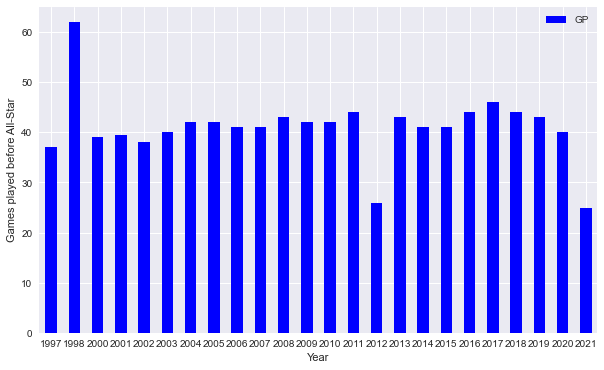

In [30]:
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
plt.rcParams['figure.figsize'] = (10, 6)
GP_pivot = nba.pivot_table(index='YEAR',
                  values='GP', aggfunc=np.median)
GP_pivot.plot(kind='bar', color='blue')
plt.xlabel('Year')
plt.ylabel('Games played before All-Star')
plt.xticks(rotation=0)
plt.show()

As seen, there seems to be a problem in the NBA Stats website for 1997-98 season as the data recorded is from the full season:

In [31]:
nba[nba['YEAR'] == 1998].head()

,PLAYER_NAME,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,...,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF
10320,A.C. Green,DAL,34.0,82,20,62,0.244,32.3,3.0,6.5,...,1.0,23.0,1985,1998,82.0,20.0,62.0,0.244,0.0,W
10321,Aaron McKie,PHI,25.0,81,34,47,0.420,22.4,1.7,4.7,...,1.0,17.0,1994,1998,82.0,31.0,51.0,0.378,0.0,E
10322,Aaron Williams,SEA,26.0,65,49,16,0.754,11.6,1.8,3.4,...,0.0,0.0,1993,1998,82.0,61.0,21.0,0.744,0.0,W
10323,Adam Keefe,UTA,28.0,80,61,19,0.763,25.6,2.9,5.3,...,1.0,10.0,1992,1998,82.0,62.0,20.0,0.756,0.0,W
10324,Adonal Foyle,GSW,23.0,55,9,46,0.164,12.0,1.3,3.1,...,1.0,8.0,1997,1998,82.0,19.0,63.0,0.232,0.0,W


Therefore we can remove the data from this year for our study:

In [32]:
nba = nba[nba['YEAR'] != 1998]
nba.describe()

,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,...,DRAFT,ROUND,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR
count,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,...,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000,10344.000000
mean,27.078210,34.743329,17.316512,17.426817,0.488795,20.296636,3.049700,6.834658,0.431988,0.597583,...,1682.528809,1.076759,17.945862,2004.490719,2010.276392,50.885151,25.363012,25.522138,0.498403,0.057908
std,4.335577,16.151923,10.483477,9.805301,0.191237,10.301185,2.232511,4.747950,0.107640,0.710232,...,735.434128,0.654826,16.430770,8.114662,6.820489,6.014755,8.522946,8.543098,0.155650,0.233581
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1976.000000,1997.000000,30.000000,4.000000,4.000000,0.077000,0.000000
25%,24.000000,22.000000,9.000000,10.000000,0.362000,11.600000,1.300000,3.100000,0.393000,0.000000,...,1994.000000,1.000000,3.000000,1999.000000,2005.000000,49.000000,19.000000,19.000000,0.388000,0.000000
50%,26.000000,39.000000,17.000000,17.000000,0.500000,19.800000,2.500000,5.700000,0.437000,0.300000,...,2002.000000,1.000000,14.000000,2004.000000,2011.000000,52.000000,25.000000,25.000000,0.500000,0.000000
75%,30.000000,49.000000,25.000000,24.000000,0.618000,28.900000,4.400000,9.700000,0.481000,1.000000,...,2009.000000,1.000000,29.000000,2011.000000,2016.000000,54.000000,32.000000,32.000000,0.611000,0.000000
max,43.000000,61.000000,48.000000,48.000000,1.000000,44.000000,11.900000,27.500000,1.000000,5.100000,...,2020.000000,8.000000,165.000000,2020.000000,2021.000000,61.000000,48.000000,48.000000,0.923000,1.000000


It needs to be noted that the games played for 2012 and 2021 are also lower than usual since there was another lockout in the beginning of 2011-12 season which got resolved in December. And last season had to start in December as well due to Covid delaying the end of 2020 season. However in both cases the All-Star games were organized and players had about 25 games which is enough to evaluate. As a result, we will keep these 2 years in the dataset.

## Feature Engineering

From experience of following the league, we know that games played is used a filter to eliminate players from all-star contention. So we need a feature that describes how available a player was in the season:

In [33]:
nba['GP_PCT'] = nba['GP'] / nba['TEAM_GP']
nba['GP_PCT'].describe()

count    10344.000000
mean         0.683282
std          0.305502
min          0.016949
25%          0.452830
50%          0.788462
75%          0.959184
max          1.133333
Name: GP_PCT, dtype: float64

There are some players who get traded before or during the All-Star break to a new team. NBA Stats website lists the players' teams that they finish the season with. In the case of traded players, this results in a couple of percentage points more or less than the actual percentage of games played. This is not significant since team schedules usually only differ by 3-4 games:

In [34]:
nba[nba['YEAR'] == 2019]['TEAM_GP'].value_counts()

57.0    201
58.0    136
59.0    134
56.0     31
Name: TEAM_GP, dtype: int64

However, this results in some players having more than 100% games played, which can be rounded down to 100%:

In [35]:
nba.loc[nba['GP_PCT'] > 1, 'GP_PCT'] = 1
nba['GP_PCT'].describe()

count    10344.000000
mean         0.683139
std          0.305341
min          0.016949
25%          0.452830
50%          0.788462
75%          0.959184
max          1.000000
Name: GP_PCT, dtype: float64

Prior to 2017, the starting 5s in the all-star games were chosen purely by fan votes. This meant that some popular players got voted in despite not being deserving due to on-court performance. We can use the new availability feature to look for these outliers:

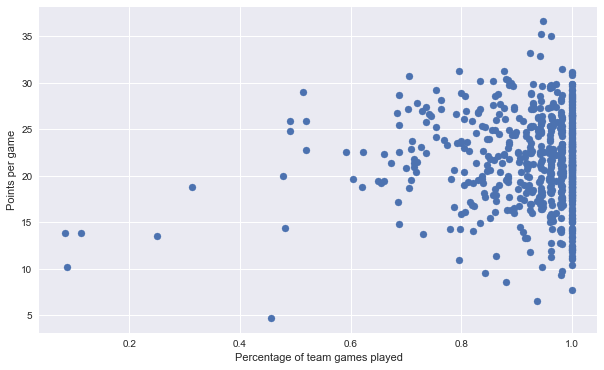

In [36]:
selected = nba[nba['ALLSTAR'] == 1]
plt.scatter(x=selected['GP_PCT'], y=selected['PTS'])
plt.ylabel('Points per game')
plt.xlabel('Percentage of team games played')
plt.show()

As seen, most all-stars played the majority of their team's games. Looking at the graph we can see there are 5 outliers to the left of the graph having played less than 40% of their team's games:

In [37]:
selected[selected['GP_PCT'] < 0.4]

,PLAYER_NAME,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,...,PICK,DEBUT,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,ALLSTAR,CONF,GP_PCT
3646,Kobe Bryant,LAL,35.0,6,2,4,0.333,29.5,5.2,12.2,...,13.0,1996,2014,53.0,18.0,35.0,0.340,1.0,W,0.113208
5177,Yao Ming,HOU,30.0,5,1,4,0.200,18.1,3.6,7.4,...,1.0,2002,2011,57.0,26.0,31.0,0.456,1.0,W,0.087719
6873,Shaquille O'Neal,MIA,35.0,13,8,5,0.615,24.7,5.7,10.9,...,1.0,1992,2007,52.0,26.0,26.0,0.500,1.0,E,0.250000
8644,Vince Carter,TOR,26.0,15,8,7,0.533,29.9,7.5,17.4,...,5.0,1998,2003,48.0,14.0,34.0,0.292,1.0,E,0.312500
9245,Grant Hill,ORL,28.0,4,1,3,0.250,33.1,4.8,10.8,...,3.0,1994,2001,48.0,25.0,23.0,0.521,1.0,E,0.083333


Injury forced all of these 5 superstars to miss those games, and 3 of them could not even participate in the all-star game. So we can remove these outliers that can affect our regression model:

In [38]:
nba.drop(nba.loc[(nba['ALLSTAR'] == 1) & (nba['GP_PCT'] < 0.4)].index, inplace=True)
nba.shape

(10339, 49)

The graph also reveals another player who has scored less than 5 points per game and played only about 45% of his team's games. That player turns out be Dirk Nowitzki, who together with Dwyane Wade got added to the roster in 2019 by the league to honor their careers, as they were both retiring. Since it wasn't a performance-based selection, these 2 outliers can be removed as well:

In [39]:
nba.drop(nba.loc[(nba['PLAYER_NAME'] == 'Dirk Nowitzki') & (nba['YEAR'] == 2019)].index, inplace=True)
nba.drop(nba.loc[(nba['PLAYER_NAME'] == 'Dwyane Wade') & (nba['YEAR'] == 2019)].index, inplace=True)
nba.shape

(10337, 49)

At this point, we can check how many all-stars are left in our data:

In [40]:
nba['ALLSTAR'].value_counts()

0.0    9745
1.0     592
Name: ALLSTAR, dtype: int64

As seen, there are about 16 times as many non all-stars than all-stars which is a called a class imbalance. This causes a major issue when we use accuracy as a metric as a classifier can predict 0 for every row, and still have high accuracy. 

At this point, we can use undersampling to filter out some of the non all-stars to aid the classifiers in making predictions. As we have done above with the all-stars, we can drop every player who appeared in less than 40 % of their teams' games:

In [41]:
nba.drop(nba.loc[nba['GP_PCT'] < 0.4].index, inplace=True)
nba['ALLSTAR'].value_counts()

0.0    7484
1.0     592
Name: ALLSTAR, dtype: int64

However, there are still many more non all-stars than all-stars. The next feature we can use to filter out non all-stars is the minutes played. If we check how many minutes the all-stars average:

In [42]:
nba[nba['ALLSTAR'] == 1]['MIN'].describe()

count    592.000000
mean      36.165203
std        2.987963
min       26.700000
25%       34.300000
50%       36.300000
75%       38.100000
max       44.000000
Name: MIN, dtype: float64

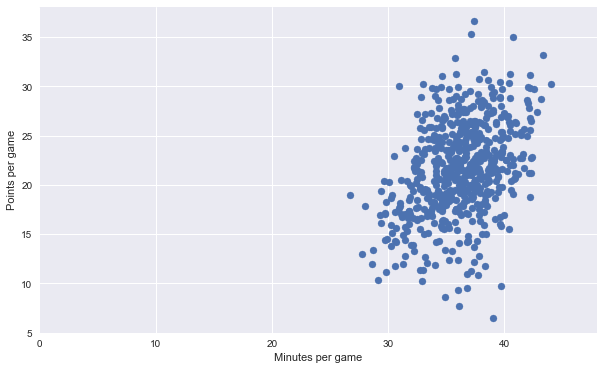

In [43]:
selected = nba[nba['ALLSTAR'] == 1]
plt.scatter(x=selected['MIN'], y=selected['PTS'])
plt.ylabel('Points per game')
plt.xlabel('Minutes per game')
plt.xlim(0,48)
plt.show()

We can see that none of the all-stars played less than 26 minutes per game. Therefore we can use 24 minutes (half of the duration of a full game) as the lower threshold for minutes played and drop every player below that:

In [44]:
nba.drop(nba.loc[nba['MIN'] < 24].index, inplace=True)
nba['ALLSTAR'].value_counts()

0.0    3251
1.0     592
Name: ALLSTAR, dtype: int64

As seen, we were able to reduce the imbalance to about 6 to 1 which should be manageable for the classifier.

Now if we look at some of our numeric columns, we can see a big difference between the range of each:

In [45]:
nba[['PTS', 'AST', 'W_PCT']].describe()

,PTS,AST,W_PCT
count,3843.000000,3843.000000,3843.000000
mean,14.190840,3.165418,0.502566
std,5.264112,2.098790,0.156047
min,3.100000,0.200000,0.068000
25%,10.300000,1.600000,0.389000
50%,13.200000,2.500000,0.510000
75%,17.400000,4.300000,0.615000
max,36.600000,12.600000,0.944000


In order to make sure these values are equally weighted within our model, we'll need to rescale the data. We also need to rank these players within their positions in their respective conferences in order to fit the selection criteria. We can't ask our model to identify all 24 players as guards or from western conference only. As a reminder, the selection process is:

Prior to 2013:

    East --> 4 Guards, 2 Forwards, 1 Center, 3 Frontcourt (F or C) and 2 Wildcards(G, F or C) 
    West --> 4 Guards, 2 Forwards, 1 Center, 3 Frontcourt (F or C) and 2 Wildcards(G, F or C)

Since 2013:

    East --> 4 Guards, 6 Frontcourt (F or C) and 2 Wildcards(G, F or C) 
    West --> 4 Guards, 6 Frontcourt (F or C) and 2 Wildcards(G, F or C)

Therefore we can use percentile ranks among certain groups to find the best-performing players for each category:

In [46]:
nba['POS'].value_counts()

G      1411
F      1105
C       356
G-F     345
C-F     245
F-C     223
F-G     158
Name: POS, dtype: int64

In [47]:
pos_type = ['G', 'F', 'C']
conf_type = ['E', 'W']

for year in range(1997,2022):
    for conf in conf_type:
        for pos in pos_type:
            nba_year = nba[nba['YEAR'] == year]
            nba_group = nba_year[(nba_year['POS'].str.contains(pos)) & (nba_year['CONF'] == conf)]
            nba.loc[nba['YEAR'] == year, 'PTS_' + conf + pos] = nba_group['PTS'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'REB_' + conf + pos] = nba_group['REB'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'AST_' + conf + pos] = nba_group['AST'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'STL_' + conf + pos] = nba_group['STL'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'BLK_' + conf + pos] = nba_group['BLK'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'FP_' + conf + pos] = nba_group['NBA_FANTASY_PTS'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'TO_' + conf + pos] = nba_group['TOV'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'W_PCT_' + conf + pos] = nba_group['W_PCT'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'FG_PCT_' + conf + pos] = nba_group['FG_PCT'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'FG3_PCT_' + conf + pos] = nba_group['FG3_PCT'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'FT_PCT_' + conf + pos] = nba_group['FT_PCT'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'DD_' + conf + pos] = nba_group['DD2'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'TD_' + conf + pos] = nba_group['TD3'].rank(pct = True)
            nba.loc[nba['YEAR'] == year, 'PM_' + conf + pos] = nba_group['PLUS_MINUS'].rank(pct = True)

nba.describe()

,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,...,BLK_WC,FP_WC,TO_WC,W_PCT_WC,FG_PCT_WC,FG3_PCT_WC,FT_PCT_WC,DD_WC,TD_WC,PM_WC
count,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.000000,3843.00000,3843.000000,3843.000000,...,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000
mean,27.430653,45.452771,22.933906,22.518865,0.502566,31.365756,5.252615,11.51210,0.456916,1.015691,...,0.528395,0.528395,0.528395,0.528395,0.528395,0.528395,0.528395,0.528395,0.528395,0.528395
std,4.039120,8.556883,8.528899,8.124093,0.156047,4.506355,1.867728,3.93101,0.051630,0.847181,...,0.287333,0.288493,0.287266,0.288379,0.288479,0.257044,0.288479,0.287752,0.131696,0.288425
min,19.000000,13.000000,2.000000,2.000000,0.068000,24.000000,1.300000,2.90000,0.312000,0.000000,...,0.050000,0.043478,0.043478,0.043478,0.043478,0.142857,0.043478,0.045455,0.366667,0.043478
25%,24.000000,41.000000,17.000000,16.000000,0.389000,27.500000,3.900000,8.50000,0.423000,0.100000,...,0.281250,0.277778,0.281250,0.277778,0.277778,0.333333,0.277778,0.275000,0.472222,0.277778
50%,27.000000,48.000000,23.000000,22.000000,0.510000,31.200000,5.000000,10.90000,0.449000,1.000000,...,0.522727,0.529412,0.533333,0.529412,0.529412,0.382353,0.529412,0.529412,0.500000,0.529412
75%,30.000000,52.000000,29.000000,28.000000,0.615000,34.900000,6.500000,14.00000,0.484000,1.600000,...,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.781250,0.522727,0.777778
max,41.000000,61.000000,48.000000,48.000000,0.944000,44.000000,11.900000,27.50000,0.725000,5.100000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we have the most well-known statistical categories on a 0-1 scale. The resulting missing values can be filled with 0 to indicate that they have no weight for the given player.

In [48]:
nba = nba.fillna(0)
nba[nba['YEAR'] == 2021].sort_values('PTS_WF', ascending = False).head()

,PLAYER_NAME,TEAM,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,...,BLK_WC,FP_WC,TO_WC,W_PCT_WC,FG_PCT_WC,FG3_PCT_WC,FT_PCT_WC,DD_WC,TD_WC,PM_WC
305,Luka Doncic,DAL,22.0,32,17,15,0.531,35.2,10.0,20.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,Kawhi Leonard,LAC,30.0,30,20,10,0.667,34.6,9.6,18.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,LeBron James,LAL,36.0,36,24,12,0.667,34.6,9.7,19.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,Zion Williamson,NOP,20.0,34,15,19,0.441,33.1,9.9,16.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,Brandon Ingram,NOP,23.0,36,15,21,0.417,34.8,8.5,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can train a logistic regression model using all of our new scaled features to see how well they perform in predicting the all-stars. We can limit the example on guards for clarity:

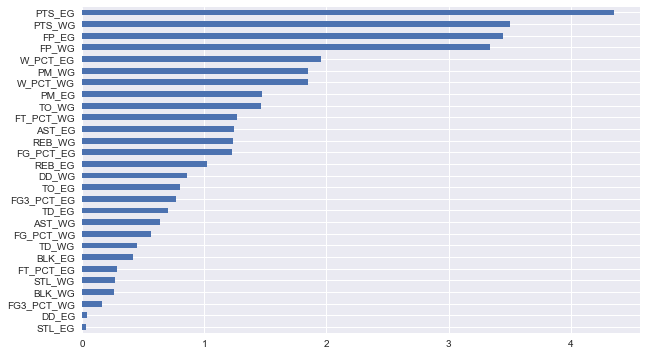

In [49]:
from sklearn.linear_model import LogisticRegression

columns = ['PTS_WG', 'REB_WG', 'AST_WG', 'STL_WG', 'BLK_WG', 'FP_WG',
          'PTS_EG', 'REB_EG', 'AST_EG', 'STL_EG', 'BLK_EG', 'FP_EG',
          'W_PCT_WG', 'W_PCT_EG', 'PM_WG', 'PM_EG', 'FG_PCT_WG', 'FG_PCT_EG',
          'FG3_PCT_WG', 'FG3_PCT_EG', 'FT_PCT_WG', 'FT_PCT_EG', 
           'DD_WG', 'DD_EG', 'TD_WG', 'TD_EG', 'TO_WG', 'TO_EG']

nba_guard = nba[nba['POS'].str.contains('G')]

lr = LogisticRegression()
lr.fit(nba_guard[columns], nba_guard['ALLSTAR'])
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0],
                               index=nba_guard[columns].columns)
feature_importance.abs().sort_values().plot.barh()
plt.show()

As seen, points, winning percentage and plus-minus seem to be 3 best features on the guard dataset. Also we can use Fantasy Points (FP) instead of the other traditional stats individually since it is a combination of them:

    FP = Pts: 1 Rebs: 1.2 Ast: 1.5 Stl: 3 Blocks: 3 TO: -1

Therefore we can modify the dataframe to include accordingly:

In [50]:
# Create a "clean" dataframe
nbamod = nba.copy().reset_index(drop=True)
# Delete all columns containing the lesser traditional stats
del_col = ['REB', 'AST', 'STL', 'BLK', 'TO', 'FT', 'FG', 'DD', 'TD']
for col in del_col:
    nbamod.drop(nbamod.columns[nbamod.columns.str.contains(col)], axis=1, inplace=True)

We can delete the original numerical columns:

In [51]:
# Original player stats
nbamod.drop(nbamod.columns[1:13], axis=1, inplace=True)
# Original team stats
nbamod.drop(nbamod.columns[nbamod.columns.str.contains('TEAM')], axis=1, inplace=True)

We can also get rid of player bio data like draft or country:

In [52]:
# Player bio data
nbamod.drop(nbamod.columns[2:9], axis=1, inplace=True)

Now we have the following remaining features:

In [53]:
nbamod.dtypes.value_counts()

float64    26
object      3
int64       1
dtype: int64

Our aim is to end up with all numerical columns since they can be used natively with scikit-learn. So we need to check the object columns before converting them to numerical:

In [54]:
object_cols = nbamod.select_dtypes(include=['object'])
for col in object_cols:
    print(nbamod[col].value_counts())

Dirk Nowitzki       19
LeBron James        18
Carmelo Anthony     17
Pau Gasol           17
Tim Duncan          17
                    ..
Gheorghe Muresan     1
Theo Maledon         1
Roshown McLeod       1
Muggsy Bogues        1
Noah Vonleh          1
Name: PLAYER_NAME, Length: 864, dtype: int64
G      1411
F      1105
C       356
G-F     345
C-F     245
F-C     223
F-G     158
Name: POS, dtype: int64
E    1950
W    1893
Name: CONF, dtype: int64


We will only use PLAYER_NAME to check the predictions visually, they won't be part of the features to train. We can rename it for short:

In [55]:
nbamod = nbamod.rename(columns={"PLAYER_NAME": "PLAYER"})

As seen POS feature has 7 unique values, however upon closer inspection, we see that G-F and F-G should be regarded as the same. Therefore we need to first rename those positions:

In [56]:
nbamod['POS'] = nbamod['POS'].replace(['G-F', 'F-G'], 'GF')
nbamod['POS'] = nbamod['POS'].replace(['C-F', 'F-C'], 'FC')
nbamod['POS'].value_counts()

G     1411
F     1105
GF     503
FC     468
C      356
Name: POS, dtype: int64

Now that we have truly unique values, we can convert these columns to categorical:

In [57]:
cat_columns = ['POS', 'CONF']
dummy_nba = pd.get_dummies(nbamod[cat_columns])
nbamod = pd.concat([nbamod, dummy_nba], axis=1)

In [58]:
nbamod.head()

,PLAYER,POS,YEAR,ALLSTAR,CONF,GP_PCT,PTS_EG,FP_EG,W_PCT_EG,PM_EG,...,FP_WC,W_PCT_WC,PM_WC,POS_C,POS_F,POS_FC,POS_G,POS_GF,CONF_E,CONF_W
0,Aaron Gordon,F,2021,0.0,W,0.527778,0.000000,0.000000,0.000000,0.00000,...,0.00,0.000000,0.000000,0,1,0,0,0,0,1
1,Al Horford,FC,2021,0.0,E,0.666667,0.000000,0.000000,0.000000,0.00000,...,0.00,0.000000,0.000000,0,0,1,0,0,1,0
2,Alec Burks,G,2021,0.0,E,0.675676,0.229167,0.145833,0.666667,0.78125,...,0.00,0.000000,0.000000,0,0,0,1,0,1,0
3,Andre Drummond,C,2021,0.0,W,0.675676,0.000000,0.000000,0.000000,0.00000,...,0.75,0.166667,0.083333,1,0,0,0,0,0,1
4,Andrew Wiggins,F,2021,0.0,W,1.000000,0.000000,0.000000,0.000000,0.00000,...,0.00,0.000000,0.000000,0,1,0,0,0,0,1


In [59]:
nbamod.shape

(3843, 37)

## Error Metric

We now have a filtered dataset with engineered features. Before diving in and selecting an algorithm to apply to the data, we should select an error metric. As stated earlier, the usual accuracy metric will not work here since we have class imbalance, meaning there are still 6 non all-stars for every all-star. So even if we predicted every player a non all-star, we still get a high accuracy. 

In this case, we don't want to use accuracy and should instead use metrics that tell us the number of false positives and false negatives. This means that we should optimize for high recall (true positive rate) and low fall-out (false positive rate). We can calculate false positive rate and true positive rate, using the numbers of true positives, true negatives, false negatives, and false positives. 

We can start with logistic regression:

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cols = nbamod.columns
train_cols = cols.drop(['PLAYER', 'YEAR', 'ALLSTAR', 'POS', 'CONF'])
features = nbamod[train_cols]
target = nbamod['ALLSTAR']

# Instantiate model object.
lr = LogisticRegression()

# Make predictions using 10-fold cross-validation.
predictions = cross_val_predict(lr, features, target, cv=10)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (nbamod['ALLSTAR'] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (nbamod['ALLSTAR'] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (nbamod['ALLSTAR'] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (nbamod['ALLSTAR'] == 0)
tn = len(predictions[tn_filter])

# Compute confusion matrix to show a summary
cm = confusion_matrix(target, predictions)

print(cm)

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print('True Positive Rate: {}'.format(tpr))
print('False Positive Rate: {}'.format(fpr))

score = f1_score(nbamod['ALLSTAR'], predictions)
print('F1 Score: {}'.format(score))

[[3195   56]
 [ 204  388]]
True Positive Rate: 0.6554054054054054
False Positive Rate: 0.017225469086434943
F1 Score: 0.7490347490347491


We can see that the model achieves an accuracy score of 75% which is a good start. Our true positive rate is around 65%, and our false positive rate is around 1.7%. So the model does a good job of identifying who is not an all-star, but it can only identify about 65% of the all-stars. 

Let's try a weighted approach to penalize certain rows more as a way to counter class imbalance. Setting class_weight to balanced will automatically set a penalty based on the number of 1s and 0s in the column (in our case it will be about 5.5):

In [61]:
# Instantiate model object with class weight.
lr = LogisticRegression(class_weight='balanced')

# Make predictions using 10-fold cross-validation.
predictions = cross_val_predict(lr, features, target, cv=10)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (nbamod['ALLSTAR'] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (nbamod['ALLSTAR'] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (nbamod['ALLSTAR'] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (nbamod['ALLSTAR'] == 0)
tn = len(predictions[tn_filter])

# Compute confusion matrix to show a summary
cm = confusion_matrix(target, predictions)

print(cm)

# Rates
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print('True Positive Rate: {}'.format(tpr))
print('False Positive Rate: {}'.format(fpr))

score = f1_score(nbamod['ALLSTAR'], predictions)
print('F1 Score: {}'.format(score))

[[2853  398]
 [  39  553]]
True Positive Rate: 0.9341216216216216
False Positive Rate: 0.12242386957859121
F1 Score: 0.7167854828256643


We can see that the true positive rate is increased to 93%, but the number of false positives are also scaled upwards resulting in a 12% rate meaning that the model overcorrected so we have about 398 predicted all-stars who were not chosen so in reality. F1 score also represents this as it decreased to 72%.

## Algorithm Selection and Tuning

Instead of testing parameters and weights one by one to find the best-performing model, we can use GridSearchCV to go through 3 different algorithms with varying hyperparameters:

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

cols = nbamod.columns
train_cols = cols.drop(['PLAYER', 'YEAR', 'ALLSTAR', 'POS', 'CONF'])
features = nbamod[train_cols]
target = nbamod['ALLSTAR']

models = [
    {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(),
        'hyperparameters':
            {
                'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                'class_weight': [None, 'balanced', {0: 3, 1: 1}],
                'max_iter': [200]
            }
    },
    {
        'name': 'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'hyperparameters':
            {
                'n_neighbors': range(1,20,2),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'p': [1,2]
            }
    },
    {
        'name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier(random_state=1),
        'hyperparameters':
            {
                'n_estimators': [4, 6, 9],
                'criterion': ['entropy', 'gini'],
                'max_depth': [2, 5, 10],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1, 5, 8],
                'min_samples_split': [2, 3, 5],
                'class_weight': [None, 'balanced', {0: 3, 1: 1}]
            }
    }
]

for model in models:
    print(model['name'])
    print('-'*len(model['name']))
    
    grid = GridSearchCV(model['estimator'],
                        param_grid=model['hyperparameters'],
                        cv=10, scoring='f1')
    grid.fit(features, target)
    model['best_params'] = grid.best_params_
    model['best_score'] = grid.best_score_
    model['best_model'] = grid.best_estimator_
    
    print("Best Score: {}".format(model["best_score"]))
    print("Best Parameters: {}".format(model["best_params"]))
    
    predictions = cross_val_predict(model['best_model'], features, target, cv=10)
    cm = confusion_matrix(target, predictions)
    
    print("Best Predictions:\n{}\n".format(cm))

LogisticRegression
------------------
Best Score: 0.7479995175670455
Best Parameters: {'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
Best Predictions:
[[3195   56]
 [ 204  388]]

KNeighborsClassifier
--------------------
Best Score: 0.7772455801036975
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Best Predictions:
[[3143  108]
 [ 147  445]]

RandomForestClassifier
----------------------
Best Score: 0.7799349311565636
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}
Best Predictions:
[[3115  136]
 [ 125  467]]



In [63]:
nbamod['ALLSTAR'].value_counts()

0.0    3251
1.0     592
Name: ALLSTAR, dtype: int64

As seen, the best model predicts 603 all-stars about 11 more than the actual number. It can also be seen that the number of false positives are similar to the number of false negatives at around 130. This would mean that about 6 players out of 25 per year get misidentified with other players which could be an acceptable result considering the biases in the voting process. 

For instance, we can compare the predictions vs. the actual selection from last year:

In [64]:
nbamod['PREDICT'] = predictions
nbamod[(nbamod['YEAR'] == 2021) & (nbamod['PREDICT'] == 1) & (nbamod['ALLSTAR'] == 1)]['PLAYER']

5              Anthony Davis
11              Bradley Beal
27            Damian Lillard
42              Devin Booker
45          Domantas Sabonis
46          Donovan Mitchell
62     Giannis Antetokounmpo
73              James Harden
75              Jaylen Brown
76              Jayson Tatum
82               Joel Embiid
91             Julius Randle
94             Kawhi Leonard
101             Kevin Durant
108             Kyrie Irving
113             LeBron James
117              Luka Doncic
135             Nikola Jokic
145              Paul George
159            Stephen Curry
174              Zach LaVine
175          Zion Williamson
Name: PLAYER, dtype: object

In [65]:
nbamod[(nbamod['YEAR'] == 2021) & (nbamod['PREDICT'] == 1) & (nbamod['ALLSTAR'] == 0)]['PLAYER']

58       Fred VanVleet
72        Jamal Murray
103    Khris Middleton
167      Tobias Harris
168         Trae Young
Name: PLAYER, dtype: object

In [66]:
nbamod[(nbamod['YEAR'] == 2021) & (nbamod['PREDICT'] == 0) & (nbamod['ALLSTAR'] == 1)]['PLAYER']

8         Ben Simmons
20         Chris Paul
128       Mike Conley
136    Nikola Vucevic
152       Rudy Gobert
Name: PLAYER, dtype: object

Looking at the names, we can see that the current model overvalues good offensive players on winning teams more than defensive-minded players that may not average as many points. But the predicted names are either former all-stars or players considered to be near that level. 

In [67]:
nbamod[(nbamod['YEAR'] == 2021) & (nbamod['PREDICT'] == 1)]['POS'].value_counts()

G     10
F      8
GF     4
FC     4
C      1
Name: POS, dtype: int64

In [68]:
nbamod[(nbamod['YEAR'] == 2021) & (nbamod['PREDICT'] == 1)]['CONF'].value_counts()

E    15
W    12
Name: CONF, dtype: int64

The predictions also seem to be balanced in terms of positions and conferences. The model predicts 14 Backcourt(Guard) and 13 Frontcourt(Forward or Center) players as the teams usually consist of equal amounts of each. It needs to be noted that the rosters normally consist of 12 players for conference, but there are some injury replacements increasing the number of all-stars.

## Predicting the 2022 All-Stars

We can now move on to predicting the 2022 all-stars based on the current season's data. As of this writing in late December, most teams have played a minimum of 30 games which is enough to provide valuable information on potential all-stars. The voting will start on Dec. 25 and the final rosters will be announced on Feb.3, 2022. 

The current data was collected from NBA Stats website as explained in the first section:

In [69]:
pl_current = pd.read_csv('pre_allstar_player_stats_2022.csv')
tm_current = pd.read_csv('pre_allstar_team_stats_2022.csv')

In [73]:
print(pl_current.shape)
pl_current.columns[pl_current.isna().any()].tolist()

(501, 67)


[]

We can see that there are a total of 501 players who appeared in a game this season and there is no data missing. So the dataset has to go through the same data transformation steps as the training dataset:

In [74]:
# Add player positions
pl_current['POS'] = pl_current['PLAYER_ID'].map(bio.set_index('PERSON_ID')['POSITION'])

In [75]:
# Add year column
pl_current['YEAR'] = pl_current['SEASON'].str.replace(r"(-\d*)", "").astype('int64') + 1
tm_current['YEAR'] = tm_current['SEASON'].str.replace(r"(-\d*)", "").astype('int64') + 1
pl_current.head()

<ipython-input-75-08b0221f7cc9>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pl_current['YEAR'] = pl_current['SEASON'].str.replace(r"(-\d*)", "").astype('int64') + 1
<ipython-input-75-08b0221f7cc9>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tm_current['YEAR'] = tm_current['SEASON'].str.replace(r"(-\d*)", "").astype('int64') + 1


,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS,SEASON,POS,YEAR
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,29,15,14,0.517,...,88,51,104,86,18,5,"203932,1610612743",2021-22,F,2022
1,1630565,Aaron Henry,Aaron,1610612755,PHI,22.0,2,2,0,1.000,...,484,383,492,155,18,5,"1630565,1610612755",2021-22,F,2022
2,1628988,Aaron Holiday,Aaron,1610612764,WAS,25.0,30,15,15,0.500,...,282,337,308,155,18,5,"1628988,1610612764",2021-22,G,2022
3,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,26,12,14,0.462,...,390,334,405,155,18,5,"1630174,1610612738",2021-22,G-F,2022
4,1630598,Aaron Wiggins,Aaron,1610612760,OKC,22.0,12,3,9,0.250,...,398,299,389,155,18,5,"1630598,1610612760",2021-22,G,2022


In [76]:
nbanow = pl_current.copy()

# Map the team stats based on TEAM_ID
nbanow.loc[nbanow['YEAR'] == 2022, 'TEAM_GP'] = nbanow.loc[nbanow['YEAR'] == 2022, 'TEAM_ID'].map(
    tm_current[tm_current['YEAR'] == 2022].set_index('TEAM_ID')['GP'])
nbanow.loc[nbanow['YEAR'] == 2022, 'TEAM_W'] = nbanow.loc[nbanow['YEAR'] == 2022, 'TEAM_ID'].map(
    tm_current[tm_current['YEAR'] == 2022].set_index('TEAM_ID')['W'])
nbanow.loc[nbanow['YEAR'] == 2022, 'TEAM_L'] = nbanow.loc[nbanow['YEAR'] == 2022, 'TEAM_ID'].map(
    tm_current[tm_current['YEAR'] == 2022].set_index('TEAM_ID')['L'])
nbanow.loc[nbanow['YEAR'] == 2022, 'TEAM_W_PCT'] = nbanow.loc[nbanow['YEAR'] == 2022, 'TEAM_ID'].map(
    tm_current[tm_current['YEAR'] == 2022].set_index('TEAM_ID')['W_PCT'])

nbanow.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,TD3_RANK,CFID,CFPARAMS,SEASON,POS,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,29,15,14,0.517,...,18,5,"203932,1610612743",2021-22,F,2022,29,15,14,0.517
1,1630565,Aaron Henry,Aaron,1610612755,PHI,22.0,2,2,0,1.000,...,18,5,"1630565,1610612755",2021-22,F,2022,31,16,15,0.516
2,1628988,Aaron Holiday,Aaron,1610612764,WAS,25.0,30,15,15,0.500,...,18,5,"1628988,1610612764",2021-22,G,2022,31,16,15,0.516
3,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,26,12,14,0.462,...,18,5,"1630174,1610612738",2021-22,G-F,2022,31,15,16,0.484
4,1630598,Aaron Wiggins,Aaron,1610612760,OKC,22.0,12,3,9,0.250,...,18,5,"1630598,1610612760",2021-22,G,2022,29,10,19,0.345


In [77]:
# We can use the team abbreviations to keep the input short
nbanow = nbanow.rename(columns={"TEAM_ABBREVIATION": "TEAM"})

# All of the eastern conference team abbreviations over the past 25 years
east = ['IND', 'BOS', 'CHI', 'NYK', 'WAS', 'MIA', 'BKN', 'TOR', 'PHI', 'CHA', 'MIL', 'ATL',
        'CLE', 'ORL', 'DET', 'NJN', 'CHH']

nbanow['CONF'] = np.where(nbanow['TEAM'].isin(east), 'E', 'W')

nbanow.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,AGE,GP,W,L,W_PCT,...,CFID,CFPARAMS,SEASON,POS,YEAR,TEAM_GP,TEAM_W,TEAM_L,TEAM_W_PCT,CONF
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,29,15,14,0.517,...,5,"203932,1610612743",2021-22,F,2022,29,15,14,0.517,W
1,1630565,Aaron Henry,Aaron,1610612755,PHI,22.0,2,2,0,1.000,...,5,"1630565,1610612755",2021-22,F,2022,31,16,15,0.516,E
2,1628988,Aaron Holiday,Aaron,1610612764,WAS,25.0,30,15,15,0.500,...,5,"1628988,1610612764",2021-22,G,2022,31,16,15,0.516,E
3,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,26,12,14,0.462,...,5,"1630174,1610612738",2021-22,G-F,2022,31,15,16,0.484,E
4,1630598,Aaron Wiggins,Aaron,1610612760,OKC,22.0,12,3,9,0.250,...,5,"1630598,1610612760",2021-22,G,2022,29,10,19,0.345,W


In [78]:
# Find missing values
print(nbanow.shape)
missing_cols = nbanow.columns[nbanow.isna().any()].tolist()
missing_vals = nbanow[missing_cols].isna().sum()
for col in range(len(missing_cols)):
    print('{}: {} missing'.format(missing_cols[col],missing_vals[col]))

(501, 74)
POS: 4 missing


In [79]:
# Remove missing rows with 4 non all-star level players
nbanow.dropna(axis=0, subset=['POS'], inplace=True)

In [80]:
print(nbanow.shape)
nbanow.columns[nbanow.isna().any()].tolist()

(497, 74)


[]

In [81]:
# We can remove the following columns that do not contain any information on player performance
nbanow = nbanow.drop(['PLAYER_ID', 'TEAM_ID', 'NICKNAME', 'CFID', 'CFPARAMS', 'SEASON'], axis=1)

# We can also remove the columns titled rank since those ranks are not relevant to our study
nbanow = nbanow.drop(nbanow.columns[nbanow.columns.str.contains('RANK')], axis=1)

In [82]:
nbanow['GP_PCT'] = nbanow['GP'] / nbanow['TEAM_GP']
nbanow['GP_PCT'].describe()

count    497.000000
mean       0.650904
std        0.302204
min        0.030303
25%        0.437500
50%        0.741935
75%        0.906250
max        1.000000
Name: GP_PCT, dtype: float64

In [83]:
# Filtering the data based on games and minutes played
nbanow.drop(nbanow.loc[nbanow['GP_PCT'] < 0.4].index, inplace=True)
nbanow.drop(nbanow.loc[nbanow['MIN'] < 24].index, inplace=True)

In [84]:
# Scaling the data based on position and conference
pos_type = ['G', 'F', 'C']
conf_type = ['E', 'W']

for conf in conf_type:
    for pos in pos_type:
        nbanow_2022 = nbanow[nbanow['YEAR'] == 2022]
        nbanow_group = nbanow_2022[(nbanow_2022['POS'].str.contains(pos)) & (nbanow_2022['CONF'] == conf)]
        nbanow.loc[nbanow['YEAR'] == 2022, 'PTS_' + conf + pos] = nbanow_group['PTS'].rank(pct = True)
        nbanow.loc[nbanow['YEAR'] == 2022, 'FP_' + conf + pos] = nbanow_group['NBA_FANTASY_PTS'].rank(pct = True)
        nbanow.loc[nbanow['YEAR'] == 2022, 'W_PCT_' + conf + pos] = nbanow_group['W_PCT'].rank(pct = True)
        nbanow.loc[nbanow['YEAR'] == 2022, 'PM_' + conf + pos] = nbanow_group['PLUS_MINUS'].rank(pct = True)

nbanow.describe()

,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,...,W_PCT_WG,PM_WG,PTS_WF,FP_WF,W_PCT_WF,PM_WF,PTS_WC,FP_WC,W_PCT_WC,PM_WC
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.00000,179.000000,...,49.000000,49.000000,39.000000,39.000000,39.000000,39.000000,13.000000,13.000000,13.000000,13.000000
mean,26.586592,26.608939,13.469274,13.139665,0.505324,30.465363,5.522346,12.108380,0.46181,1.695531,...,0.510204,0.510204,0.512821,0.512821,0.512821,0.512821,0.538462,0.538462,0.538462,0.538462
std,4.244896,4.290456,4.675168,4.529249,0.152117,3.587326,1.922882,4.175596,0.07195,0.921883,...,0.291450,0.291561,0.292323,0.292308,0.291671,0.292279,0.299572,0.299161,0.299161,0.298748
min,19.000000,13.000000,2.000000,3.000000,0.111000,24.100000,2.300000,3.900000,0.33900,0.000000,...,0.020408,0.020408,0.025641,0.025641,0.025641,0.025641,0.076923,0.076923,0.076923,0.076923
25%,23.000000,24.000000,11.000000,9.500000,0.414000,27.700000,4.050000,8.950000,0.41700,1.100000,...,0.275510,0.265306,0.269231,0.262821,0.275641,0.269231,0.307692,0.307692,0.307692,0.307692
50%,26.000000,28.000000,13.000000,13.000000,0.500000,30.200000,5.300000,11.700000,0.44800,1.700000,...,0.510204,0.500000,0.512821,0.512821,0.525641,0.512821,0.538462,0.538462,0.500000,0.500000
75%,29.500000,30.000000,16.000000,16.000000,0.594000,33.300000,6.900000,15.000000,0.48950,2.400000,...,0.755102,0.744898,0.756410,0.756410,0.756410,0.756410,0.769231,0.769231,0.769231,0.807692
max,37.000000,33.000000,25.000000,25.000000,0.870000,37.900000,10.800000,21.600000,0.76400,5.300000,...,1.000000,1.000000,1.000000,1.000000,0.974359,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
# Fill empty rank values with 0
nbanow = nbanow.fillna(0)
# Create a "clean" dataframe
nbanowmod = nbanow.copy().reset_index(drop=True)

In [86]:
# Remove original player stats
nbanowmod.drop(nbanowmod.columns[1:32], axis=1, inplace=True)
# Remove original team stats
nbanowmod.drop(nbanowmod.columns[nbanowmod.columns.str.contains('TEAM')], axis=1, inplace=True)

In [87]:
# Rename player name column
nbanowmod = nbanowmod.rename(columns={"PLAYER_NAME": "PLAYER"})
# Unique values for player positions
nbanowmod['POS'] = nbanowmod['POS'].replace(['G-F', 'F-G'], 'GF')
nbanowmod['POS'] = nbanowmod['POS'].replace(['C-F', 'F-C'], 'FC')
nbanowmod['POS'].value_counts()

G     78
F     45
GF    24
FC    19
C     13
Name: POS, dtype: int64

In [88]:
# Convert position and conference into categorical features
cat_columns = ['POS', 'CONF']
dummy_nbanow = pd.get_dummies(nbanowmod[cat_columns])
nbanowmod = pd.concat([nbanowmod, dummy_nbanow], axis=1)
nbanowmod.shape

(179, 36)

Now we have this season's data with the same features as the training data. We can use the best-performing Random Forest Classifier from previous step to make predictions. Here are the parameters as a reminder:

In [89]:
model['best_model']

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features='log2', min_samples_split=3,
                       n_estimators=9, random_state=1)

In [90]:
cols = nbanowmod.columns
test_cols = cols.drop(['PLAYER', 'YEAR', 'POS', 'CONF'])

new_predictions = model['best_model'].predict(nbanowmod[test_cols])
nbanowmod['PREDICT'] = new_predictions

nbanowmod[nbanowmod['PREDICT'] == 1]

,PLAYER,POS,YEAR,CONF,GP_PCT,PTS_EG,FP_EG,W_PCT_EG,PM_EG,PTS_EF,...,W_PCT_WC,PM_WC,POS_C,POS_F,POS_FC,POS_G,POS_GF,CONF_E,CONF_W,PREDICT
5,Anthony Davis,FC,2022,W,0.843750,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.384615,0.153846,0,0,1,0,0,0,1,1.0
12,Brandon Ingram,F,2022,W,0.781250,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,1,0,0,0,0,1,1.0
21,Chris Paul,G,2022,W,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0,0,1,0,0,1,1.0
27,Damian Lillard,G,2022,W,0.812500,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0,0,1,0,0,1,1.0
34,DeMar DeRozan,GF,2022,E,0.896552,0.981132,0.924528,0.943396,0.943396,0.959184,...,0.000000,0.000000,0,0,0,0,1,1,0,1.0
36,Dejounte Murray,G,2022,W,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0,0,1,0,0,1,1.0
41,Devin Booker,G,2022,W,0.766667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0,0,1,0,0,1,1.0
46,Donovan Mitchell,G,2022,W,0.966667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0,0,0,1,0,0,1,1.0
56,Fred VanVleet,G,2022,E,0.965517,0.849057,0.905660,0.509434,0.867925,0.000000,...,0.000000,0.000000,0,0,0,1,0,1,0,1.0
61,Giannis Antetokounmpo,F,2022,E,0.812500,0.000000,0.000000,0.000000,0.000000,0.979592,...,0.000000,0.000000,0,1,0,0,0,1,0,1.0


According to our model, these 27 players have performed at an all-star level. If we look at the how the rosters are formed per conference:

In [91]:
predicted_west = nbanowmod[(nbanowmod['PREDICT'] == 1) & (nbanowmod['CONF'] == 'W')]
predicted_east = nbanowmod[(nbanowmod['PREDICT'] == 1) & (nbanowmod['CONF'] == 'E')]
print('Western Conference')
print('Backcourt  :  {}'.format(predicted_west[predicted_west['POS'].isin(['G','GF'])]['PLAYER'].to_list()))
print('Frontcourt :  {}\n'.format(predicted_west[predicted_west['POS'].isin(['F','FC','C'])]['PLAYER'].to_list()))
print('Eastern Conference')
print('Backcourt  :  {}'.format(predicted_east[predicted_east['POS'].isin(['G','GF'])]['PLAYER'].to_list()))
print('Frontcourt :  {}'.format(predicted_east[predicted_east['POS'].isin(['F','FC','C'])]['PLAYER'].to_list()))

Western Conference
Backcourt  :  ['Chris Paul', 'Damian Lillard', 'Dejounte Murray', 'Devin Booker', 'Donovan Mitchell', 'Luka Doncic', 'Russell Westbrook', 'Stephen Curry']
Frontcourt :  ['Anthony Davis', 'Brandon Ingram', 'Karl-Anthony Towns', 'LeBron James', 'Nikola Jokic', 'Paul George']

Eastern Conference
Backcourt  :  ['DeMar DeRozan', 'Fred VanVleet', 'James Harden', 'Jayson Tatum', 'Jrue Holiday', 'LaMelo Ball', 'Trae Young', 'Zach LaVine']
Frontcourt :  ['Giannis Antetokounmpo', 'Jimmy Butler', 'Joel Embiid', 'Kevin Durant', 'Nikola Vucevic']


As seen, there are 8 Backcourt players for both the Western and Eastern conferences. The West has 6 frontcourt players for a total of 14 players and the East has 5 for a total of 13. Some of the names like Anthony Davis and Jimmy Butler could be filtered out when we reach the end of January due to not playing enough games. Also it's highly unlikely that Westbrook and Vucevic make the team, but they seem to be rewarded right now due to being part of winning teams. Other than that our model does a good job of identifying established former all-stars and newcomers like Dejounte Murray and LaMelo Ball.

## Conclusions

In this study, we used traditional box score stats from the official NBA stats website to predict all-stars. We went through the following steps: 
* web scraping to collect data from different sources
* filtered out data using numerical features to eliminate class imbalance
* added scaled columns to compare features with the same weight
* selected features based on correlation with all-star selection
* chose F1 Score as the error metric to optimize for high recall and low fall-out
* used GridSearch to find the best-performing algorithm
* made predictions using the current season's data

Since we only used basic stats like points and games played, the current model does not take efficiency into account. It also overvalues winning percentage and hence takes 2nd or 3rd best players from a winning team rather than a better performing player from a team with less wins. Despite the disadvantages resulting from the lack of advanced stats, the model achieves 79% recall with only 4% fall-out on the training data from the past 25 years.

The model can be improved by:
* collecting advanced data such as PER, VORP or RPM from different sources
* engineering new features that incorporate player efficiency and team pace
* eliminating more non all-star rows to further reduce class imbalance
* trying other algorithms with different parameters
* ensembling multiple models to get more accurate predictions
* using multi-class classification instead of binary, for example:
    * 0: Not an All-star
    * 1: Eastern Conference All-Star
    * 2: Western Conference All-Star
* or dividing into even more classes, such as:
    * 0: Not an All-star
    * 1: Eastern Conference All-Star Frontcourt
    * 2: Eastern Conference All-Star Backcourt
    * 3: Western Conference All-Star Frontcourt
    * 4: Western Conference All-Star Backcourt